# Statistical Arbitrage with Vine Copulas (March application)
### Overview
In this notebook the paper [Statistical Arbitrage with Vine Copulas [Stübinger, Mangold, Krauss (2016)]](https://www.econstor.eu/bitstream/10419/147450/1/870932616.pdf) will partly be implemented.

The Python module *vinecopulaslab* provides both a stock ticker and a partner selection framework.

#### Sections
- Introduction
- Framework
- Performance
- Conclusion
- Learnings

### Introduction
Pairs trading with statistical arbitrage is a popular research topic for quants since the beginning of algorithmic trading. The paper that is being implmenented extends the traditional approach with a vine copulas. Further it does not focus on two partners but instead on a quadruple of stocks. We will now show how we can use the framework to build partners from historic SP500 data.

### The framework
*vinecopulaslab* can simply be imported with:

*import vinecopulaslab as vl*

Or you can import the submodules directly. The framework is presented alongside code. Let's fetch the historic SP500 closing data. It usually takes around one minute. Luckily the request is getting cached.

#### The UniverseDownloader class

In [1]:
%load_ext autoreload
%autoreload 2

from vinecopulaslab.universe import UniverseDownloader
from vinecopulaslab.partnerselection import TraditionalSelection, ExtendedSelection, GeometricSelection

import seaborn as sns
sns.set()

sp500_prices = UniverseDownloader(cache=True).historic_sp500_prices(start='2017-01-01',
                                                       end='2018-01-01')
sp500_prices.head(2)

,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,XLNX,XOM,XRAY,XRX,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,46.490002,46.299999,170.600006,29.037500,62.410000,82.610001,112.360001,39.049999,116.459999,103.480003,...,59.070000,90.889999,58.619999,27.559999,49.650002,63.209999,103.330002,86.250000,43.180000,53.590000
2017-01-04,47.099998,46.700001,172.000000,29.004999,63.290001,84.660004,115.739998,39.360001,116.739998,104.139999,...,58.639999,89.889999,59.099998,28.600000,50.389999,63.439999,104.279999,87.029999,43.799999,54.110001


We can now immediately pick quadruples for each stock in the SP500 data with traditional approach

#### The TraditionalSelection class

The TraditionalSelection is based on the subseciton of the paper 3.1.1.. It is calculating the Spearmann correlation of the daily stock returns with each other. It then filters the top 50 correlated stocks for a target stock to reduce the search space. Finally it calculates the sum of the correlation for all possible quadruples of a target stock and picks the highest score.

In [9]:
%%time
partners = TraditionalSelection().find_partners(sp500_prices)

CPU times: user 3min 37s, sys: 2min 29s, total: 6min 7s
Wall time: 6min 6s


In [7]:
partners.head(10)

TARGET_STOCK
A              [A, WAT, PKI, TMO]
AAL          [AAL, LUV, DAL, UAL]
AAP         [AAP, GPC, AZO, ORLY]
AAPL    [AAPL, AMZN, GOOGL, GOOG]
ABBV          [ABBV, PKI, A, TMO]
ABC         [ABC, HSIC, MCK, CAH]
ABMD          [ABMD, A, TMO, PKI]
ABT            [ABT, PKI, A, TMO]
ACN            [ACN, V, MA, MSFT]
ADBE          [ADBE, MA, V, MSFT]
dtype: object

In [18]:
%%time
#Or for a specific list of target stocks
TraditionalSelection().find_partners(sp500_prices, ["MSFT"])

CPU times: user 1.41 s, sys: 350 ms, total: 1.76 s
Wall time: 1.73 s


TARGET_STOCK
MSFT    [MSFT, AMZN, GOOGL, GOOG]
dtype: object

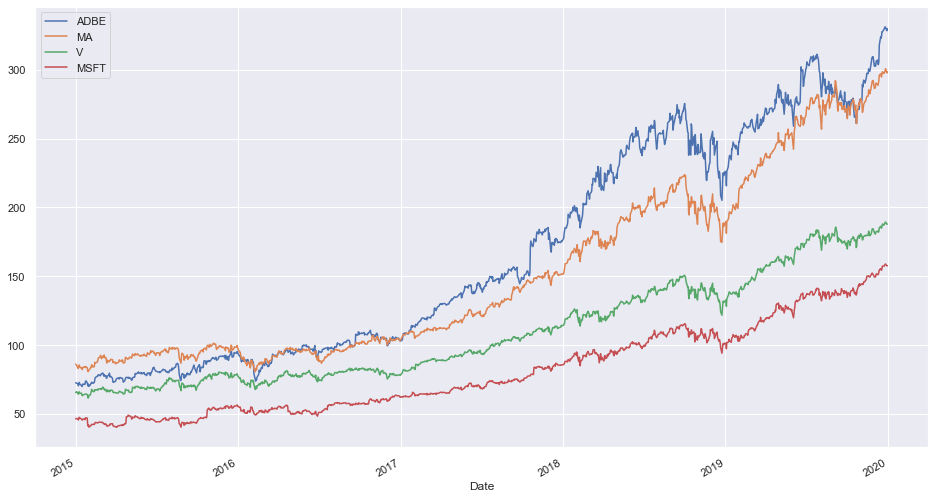

In [8]:
sample_partners = partners["ADBE"]
sp500[sample_partners].plot(figsize=(16,9));

#### The ExtendedSelection class

The ExtendedSelection is extending the the Spearman correlation by using the mean of three estimators. It is based on  Schmid, F., Schmidt, R., 2007. Multivariate extensions of Spearman’s rho and related statistics. Statistics & Probability Letters 77 (4), 407–416.

In [48]:
%%time
partners_e = ExtendedSelection().find_partners(sp500_prices)

CPU times: user 17min 27s, sys: 16min 33s, total: 34min 1s
Wall time: 34min 27s


In [51]:
partners_e.head(10)

TARGET_STOCK
A              [A, WAT, PKI, TMO]
AAL          [AAL, LUV, DAL, UAL]
AAP         [AAP, GPC, AZO, ORLY]
AAPL    [AAPL, AMZN, GOOGL, GOOG]
ABBV          [ABBV, PKI, A, TMO]
ABC         [ABC, HSIC, MCK, CAH]
ABMD          [ABMD, A, TMO, PKI]
ABT            [ABT, PKI, A, TMO]
ACN            [ACN, V, MA, MSFT]
ADBE          [ADBE, MA, V, MSFT]
dtype: object

In [24]:
%%time
ExtendedSelection().find_partners(sp500_prices, ["MSFT"])

CPU times: user 1.62 s, sys: 461 ms, total: 2.08 s
Wall time: 2.08 s


TARGET_STOCK
MSFT    [MSFT, AMZN, GOOGL, GOOG]
dtype: object

In [252]:
%%time
partners_g = GeometricSelection().find_partners(sp500_prices)

CPU times: user 1min 30s, sys: 39.4 s, total: 2min 10s
Wall time: 2min 11s


In [7]:
%%time
GeometricSelection().find_partners(sp500_prices, ["MSFT"])

CPU times: user 1.25 s, sys: 164 ms, total: 1.42 s
Wall time: 1.41 s


TARGET_STOCK
MSFT    [MSFT, FB, GOOGL, GOOG]
dtype: object

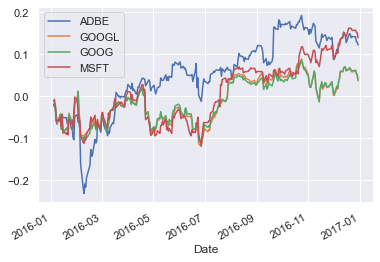

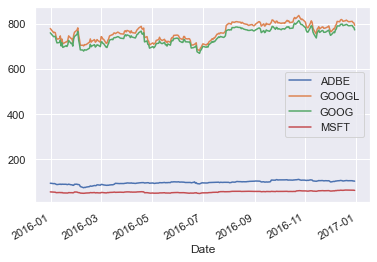

In [257]:
sample_partners = partners_g.tolist()[9]
sp500[sample_partners].pct_change(fill_method='ffill').dropna(how='all').cumsum(axis=0).plot();
sp500[sample_partners].plot();

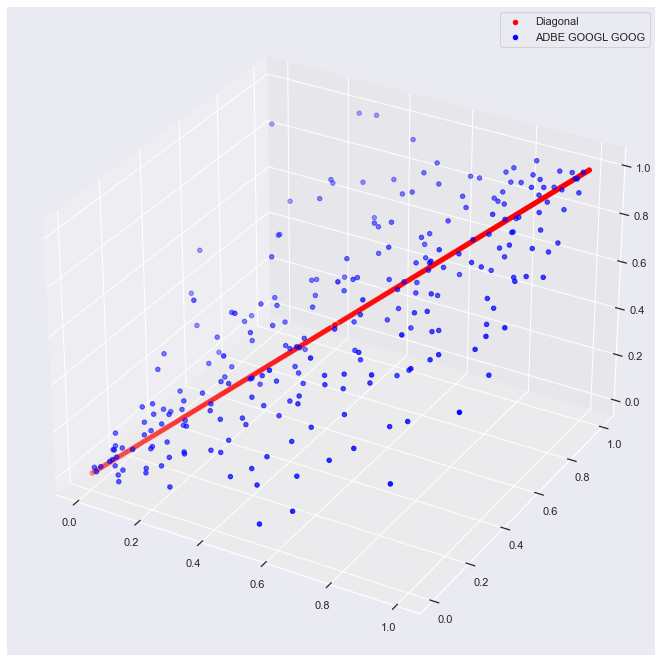

In [268]:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
sns.set()
fig = plt.figure(figsize=(12, 9))
ax = Axes3D(fig)
sample = sp500[sample_partners[:3]].pct_change(fill_method='ffill').dropna(how='all')
values = sample.rank(pct=True).values
y = np.linspace(0,1)
x = np.linspace(0,1)
z = np.linspace(0,1)
ax.scatter(values[:,0],values[:,0],values[:,0], label="Diagonal",c="red")  
ax.scatter(values[:,0],values[:,1],values[:,2], label=" ".join(sample_partners[:3]),c="blue")  
ax.legend();

In [45]:
from vinecopulaslab.partnerselection import ExtremalSelection

## Extremal Selection (status: not complete)
Currrently the extremal selection approach is not fully implemented. After testing it it was noticed there is a mistake in the vectorized version.

In [46]:
EX = ExtremalSelection()

In [52]:
%%time
partners_e = EX.find_partners(sp500)

CPU times: user 1h 26min 20s, sys: 30min 32s, total: 1h 56min 53s
Wall time: 1h 4min 27s


In [54]:
partners_e.head(10)

TARGET_STOCK
A              [A, WAT, PKI, TMO]
AAL          [AAL, LUV, DAL, UAL]
AAP           [AAP, HD, LOW, AZO]
AAPL    [AAPL, MSFT, GOOG, GOOGL]
ABBV       [ABBV, CAH, MCK, AMGN]
ABC         [ABC, AMGN, MCK, CAH]
ABMD     [ABMD, FISV, CDNS, SNPS]
ABT           [ABT, A, TMO, AMGN]
ACN         [ACN, BLK, SPGI, MCO]
ADBE           [ADBE, EFX, MA, V]
dtype: object

### Performance
For performance purposes it was tried as much as possible to use vectorized calculations.
For example the traditional approach took 30 seconds with only for loops for one target stock.
Later it got down to 2 seconds using the least for loops as possible

## Conclusion
The paper compares 4 different approaches to partner selections. The implementation for this project was mainly done in pure numpy and pandas. The main goal is to build a framework for partner selection. This is not fully completed yet. In the implementation it was mainly optimized for vectorized operation so no for-loops. For future research speed could further be improved with numba.

### Learnings
- Speed vs readibility
- Implementing a simple prototype and then making it more complex
- Learning about copulas and their use in finance


Thanks for your attention,
Franz Krekeler